In [43]:
from data_utils import form_data_file,fft_plot
import copy
from KMeans_F import validation_kmeans,choose_best_cluster_kmeans,scale_PCA_data,evaluate_test
from KNN_F import choose_best_knn,cluster_gen,test_KNN,caluculate_accuracy
import librosa.display
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
from sklearn.model_selection import train_test_split
import operator
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

All the sample sounds were extracted to the following file.

In [2]:
#Location of all sound files
abs_path='C:/Users/13152/Downloads/Urban_sounds'

In [3]:
ipd.Audio(abs_path+'/'+'doorCar01.wav')

First we will estract the main features of the wav files and save them

In [6]:
#'/data_file.csv'
form_data_file(abs_path,'/data_file.csv')

Load the features to dataframe

In [7]:
data = pd.read_csv(abs_path+'/data_file.csv')
# assign label to sample
data["Label"]=data['filename'].apply(lambda x: x.split('.')[0][:-2])
data = shuffle(data).reset_index(drop=True)

Some helpful info

In [8]:
data["Label_new"]=data["Label"].apply(lambda x:'BG' if (len(x.split('_'))>1 and x.split('_')[-1]=='bg') else x)
classes_new=list(set(data["Label_new"]))
classes_old=list(set(data["Label"]))
bg_labels    =[x for x in classes_old if x[-2:]=='bg']
not_bg_labels=[x for x in classes_old if x[-2:]!='bg']
audios       =[x+'01.wav' for x in classes_old if x[-2:]!='bg']
audios_bg    =[x+'01.wav' for x in classes_old if x[-2:]=='bg']

Data exploration and analysis

- Let us take a look at the time domain representation of our data
  
  Not background sounds

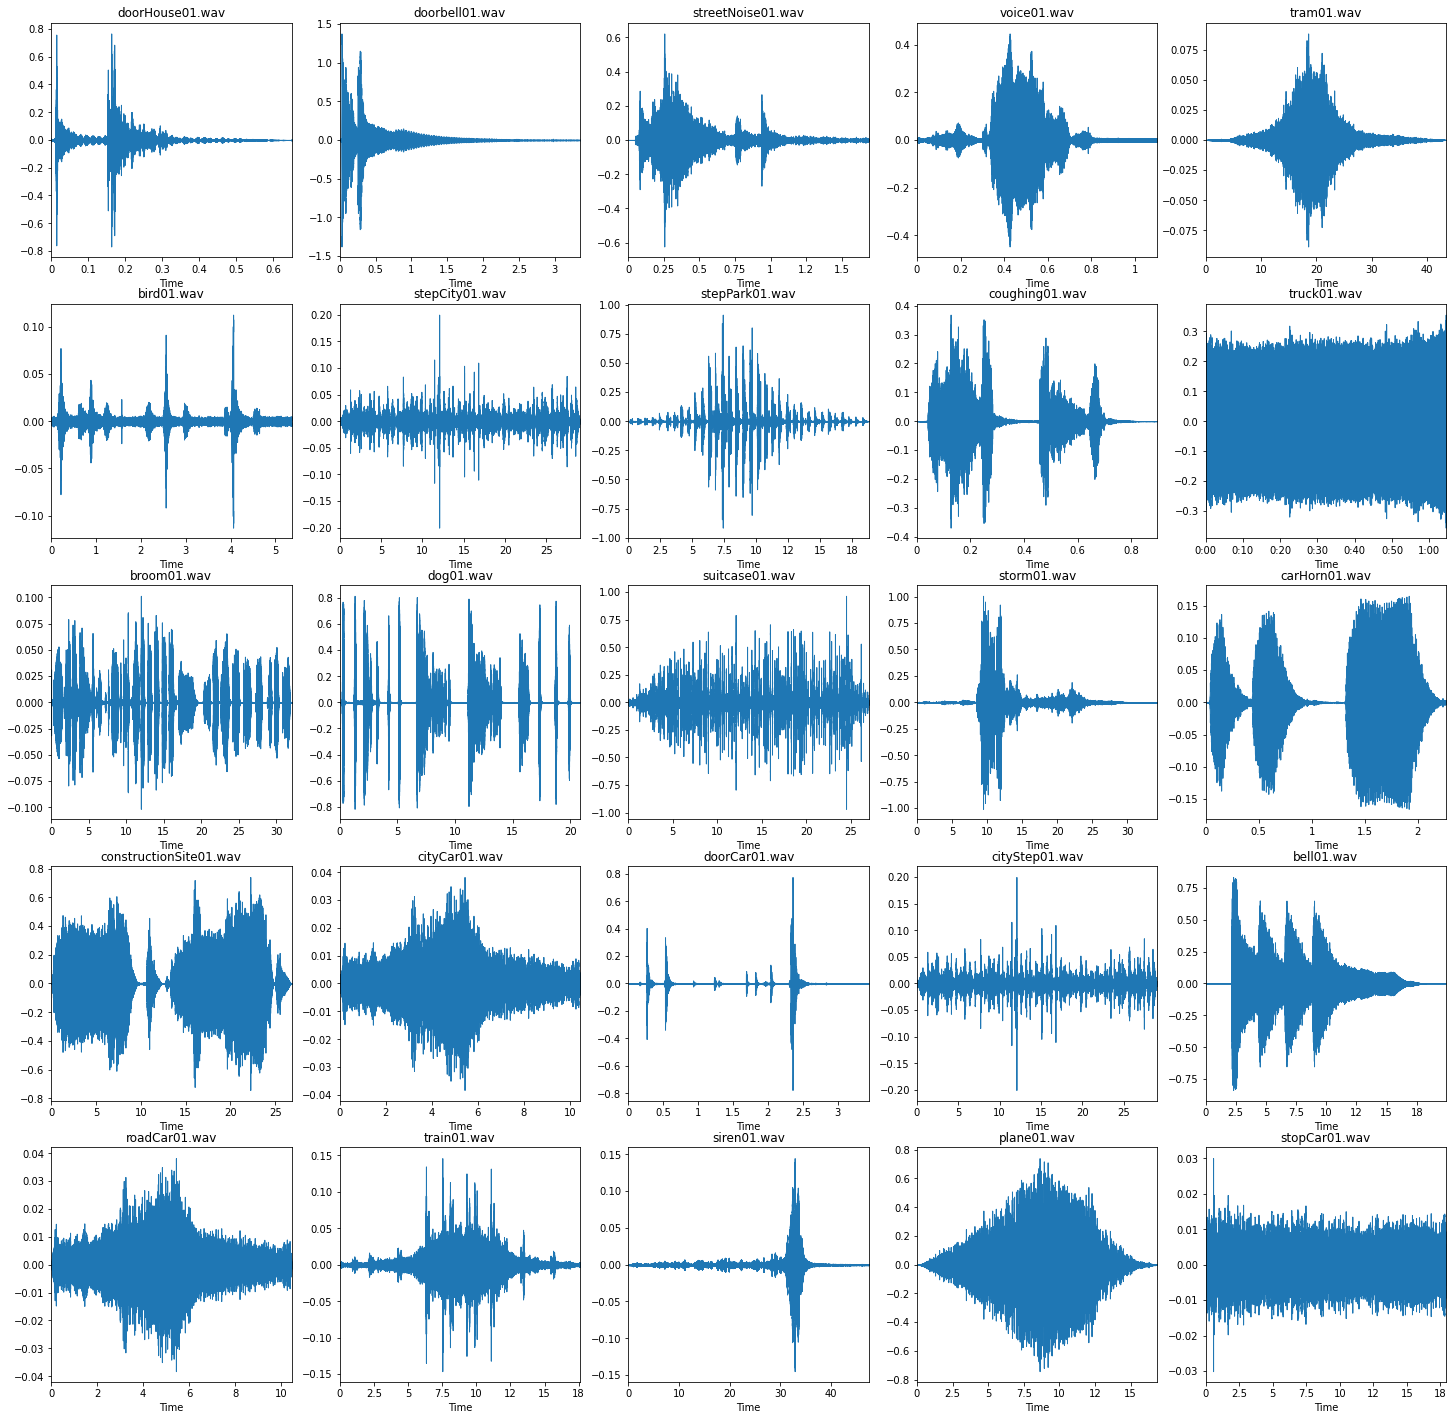

In [9]:
# Standart audios 
fig, axs = plt.subplots(5, 5,figsize=(25, 25))
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, i*5+j+1)
        audio_path=audios[i*5+j]
        plt.title(audio_path)
        x , sr = librosa.load(abs_path+'/'+audio_path)
        librosa.display.waveplot(x, sr=sr)

Background sounds

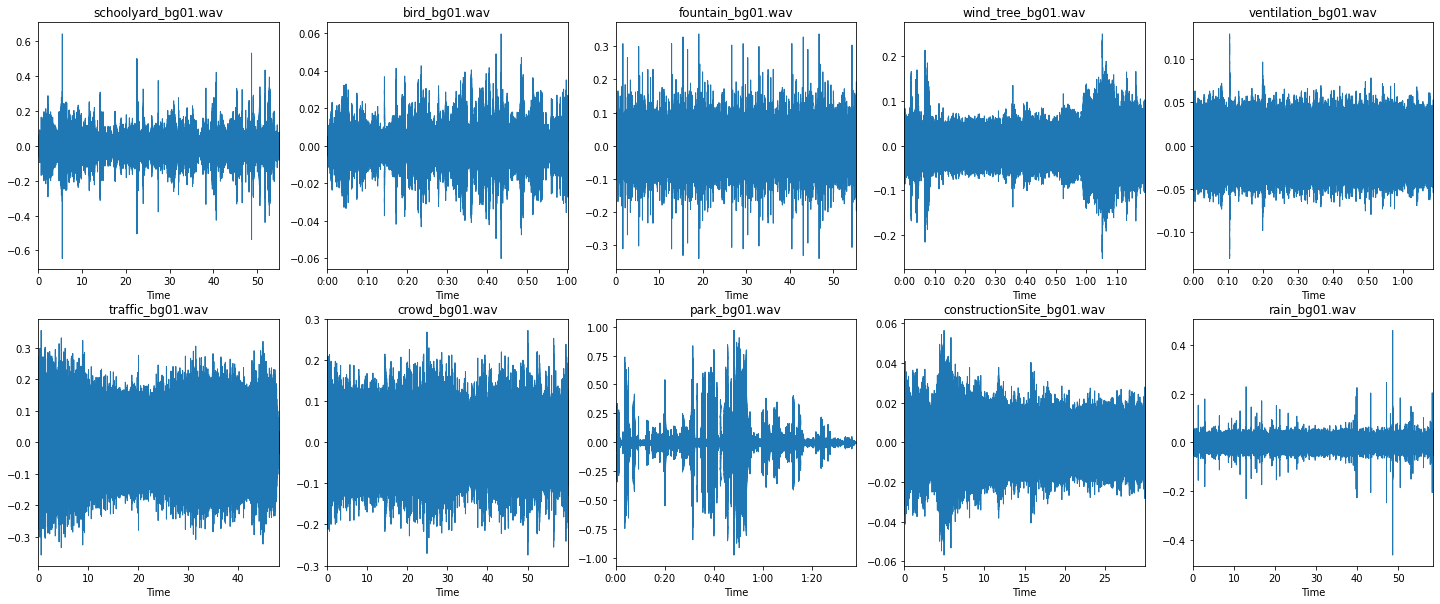

In [10]:
#Backgroud audios 
fig, axs = plt.subplots(5, 5,figsize=(25, 10))
for i in range(2):
    for j in range(5):
        plt.subplot(2, 5, i*5+j+1)
        audio_path=audios_bg[i*5+j]
        plt.title(audio_path)
        x , sr = librosa.load(abs_path+'/'+audio_path)
        librosa.display.waveplot(x, sr=sr)

Ft spectrum

broom05.wav


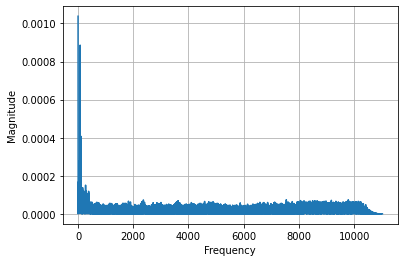

In [13]:
j=0
fil= 'broom05.wav'#audios[12]# 
sound = abs_path+'/'+fil
print(fil)
y, sr = librosa.load(sound, mono=True, duration=30)
fft_plot(y,sr)

Exploratory Analysis

1- we have ~400 samples and 35 classes (assigning classes to each background sound category).Assuming equal distribution 
we will see that it is not the case), makes it ~ 15 samples per class,probably will make it diffucult to unsupervised
learning algorithm to generalize.Also, the spectral characteristics of the background sound resemble each other, thus
we will assign one category "BG" to all of them.

2- Spectral characteristics of the following ['cityCar','truck','stepPark','broom','stopCar','cityStep','streetNoise','constructionSite','storm','plane']
resemble those of background, thus they will be as well assigned to this class.

3-The CityCar and roadCar is duplicated data, that we should remove.The CityStep and stepCity is duplicated data, that we should remove.

4- Taking look at the spectra of tram and train, and those of bell and doorbell we will make 2 separate categories for them.

In [14]:
data=data[data["Label_new"]!='roadCar']
data=data[data["Label_new"]!='stepCity']
labels_to_replace=['cityCar','truck','stepPark','broom','stopCar','cityStep','streetNoise','constructionSite','storm','plane','suitcase']
dict_replace=dict(zip(labels_to_replace, ["BG"]*len(labels_to_replace)))
data["Label_new"]=data["Label_new"].replace(dict_replace)
#The tram and train spectral characteristics might resemble each other
data["Label_new"]=data["Label_new"].replace({'tram':'train'})
#The spectral characteristics of the bell and doorbell resemple each other
data["Label_new"]=data["Label_new"].replace({'doorbell':'bell'})

Let us take a look at the samples distribution

In [15]:
print(collections.Counter(data["Label_new"]))

Counter({'BG': 254, 'dog': 23, 'bird': 18, 'voice': 14, 'carHorn': 14, 'train': 11, 'bell': 9, 'doorHouse': 8, 'coughing': 6, 'siren': 5, 'doorCar': 5})


We have a very imbalanced data set, thus we will downsample the majority group - 'BG', and upsample the minority.

In [16]:
#del data["Label"]

In [17]:
data_bg=data[data["Label_new"]=="BG"]
data_min=data[data["Label_new"]!="BG"]
#First we wil take our train and test data of minority group ( not upsamled)
df_train_min,df_test_min, y_train_min, y_test_min = train_test_split(data_min, data_min["Label_new"], test_size=0.2, random_state=42)

We will upsample the minority data, so to have approximately 20-40 smaples per class, 
and downsample BG data to take ~30 samples total, thus, the distribution will be approximately balanced

Formation of train and test sets

In [18]:
data_bg_d=data_bg.sample(n=44, random_state=1)
df_train_min_up = resample(df_train_min, replace=True,n_samples=(len(data_bg)-30),random_state=27) 
bg_train,bg_test, y_train_bg, y_test_bg = train_test_split(data_bg_d, data_bg_d["Label_new"], test_size=0.2, random_state=42)

#Form the train and test dfs
balanced_train=pd.concat((df_train_min_up,bg_train))
balanced_train = shuffle(balanced_train).reset_index(drop=True)
balanced_test=pd.concat((bg_test,df_test_min))
balanced_test = shuffle(balanced_test).reset_index(drop=True)

We have ~ 20-40 samples per class and 20 features , the number of the last should be deffinitely smaller,
thus we will keep only the mfcc1 and drop the other ones.

In [19]:
#we will frop the stdev features, since for ~20samples per class we have 20 features...
chosen_cols= [col for col in balanced_train.columns.tolist()if col.split('_')[-1]!='stdev']
chosen_cols_1=chosen_cols[:8]+chosen_cols[-1:]

balanced_train_1=balanced_train[chosen_cols_1]
balanced_test_1=balanced_test[chosen_cols_1]

Since we were told to use unsupervised learning methods we will focus on assigning our data samples to clusters.
2- algorithms , KMeans and KNN. For Kmeans we will try to assign the optimal number of cluster, for KNN we will try to find the optimal
number of neighbours.Both algorithm - should result in clusters , assigned to group of sounds .we don't belive that our algorithms will manage to distinguishe all our 11 classes since 1- for some of the classes, have
too small number of samples per original class, 2- different sample characteristics resemble those of other classes.
Thus the goal will be to assign a single cluster to several original groups.We believe that appropriate number would be 4-5 clusters.

Algorithm 1 - Kmean

Kmean is a classical unsupervised learning algorithm. 
We won't expect it to distinguish each of our 11 formed classes, but to find the optimal generalization - optimal num of cluster.

Approach:

1- We will find the optimal cluster on the training set by the elbow method.

2- For each cluster of the training set, we will assign the majority label of that class as being the main identifier.

3- We will choose accuracy metric for our evaluation - our classes are ~ balanced and all are equaly important.

4- On the validation/test sets, the assigned predicted class will be given the appropriate label, extracted on training set- this will be the predicted label, tha actual label will be the majority label of the assigned predicted cluster.

5- Label of each cluster, that do not correspond to assigned label, will be assigned to "BG" class.

In [37]:
#Kmeans
print("Choose best num for cluster")
best_clus=choose_best_cluster_kmeans(balanced_train_1)

print("Best cluster num:", best_clus)
k_m,validation_accuracy,best_dictionary,scal=validation_kmeans(balanced_train_1,best_clus)
print("Assigned clusters and categories:",best_dictionary)
print("Validation accuracy" ,round(validation_accuracy, 2))
print("Evaluate test performance ")
#Test set performance
test_data=pd.concat((df_test_min,bg_test))
#There are too many "BG" samples, we will remove some of them
test_data_1=test_data[chosen_cols_1][:-7]
x_data_test=test_data_1.iloc[:,1:-1]
y_data_test=test_data_1.iloc[:,-1:]
scaled_x_test=scal.transform(x_data_test)

pca=PCA(n_components = 0.85)
scaled_pca_x=pca.fit_transform(scaled_x_test)
scaled_pca_dataf=pd.DataFrame(scaled_pca_x)
scaled_pca_dataf["labels"]=y_data_test.values
scaled_pca_dataf["predicted_label"]=-1
data,acc=evaluate_test(scaled_pca_dataf,k_m,best_clus,best_dictionary)
print(acc)

Choose best num for cluster
Best cluster num: 5
Assigned clusters and categories: {0: 'carHorn', 1: 'dog', 2: 'BG', 3: 'train', 4: 'bird'}
Validation accuracy 0.93
Evaluate test performance 
0.68


We found that the optimal number of clusters is 5, with performance on validation set of ~ 93% and test set ~70%, which is definitely better than random guess - 20%.

Approach 2 -KNN:
 
1 - The hyperparameter to optimize will be the number of NN.

2 - At each iteration, we will find for each data point it's closest NN.

3 - Passing point by point, we will assing clusters based on majority vote (if the cluster is already formed , if not add new cluster to list). 

4- For each cluster of the training set, we will assign the majority label of that class.

5- We will choose accuracy metric for our evaluation.

6- On the validation set, the predicted class will be given the appropriate label, extracted on training set.
   Actual label will be the majority label of that class in validation set.  

8- Since we choose 5 Fold CV, for each split, we will get a accuracy assigned to each number of NN.

9- Performance will be averaged on all the 5 splits for each NN_number, and the NN num with the highest accuracy will we chosen.

10- Test set performance will be evaluated in similar maner.

In [42]:
#KNN
print("Choose best NN number")
best_nn,best_acc=choose_best_knn(balanced_train_1)
print("Best number of nn", best_nn)
print("Validation accuracy", best_acc)
print("Test accuracy",test_KNN(best_nn,balanced_train_1,test_data_1))

Choose best NN number
Best number of nn 16
Validation accuracy 0.9038461538461539
The number of clusters is 5
Test accuracy 0.44


Discussion:



Kmeans:
    Advantages
    1- fast computation.
    2-Easily adapts to new examples

    Disadvantages:
    1- Different initial partitions can result in different final clusters.    
    2- Doesn't not work well with clusters of different size and different density. (Using PCA doesn't minimize the effect)
    3- Sensitive to outliers.
    4- Scaling with number of dimensions (can be handeled using PCA)
    
    These are of some known advantages and disadvantages of the KMeans algorithm.In our case,the fact that different partitions result in different clusters- is important.This directly effects the calculated accuracy (additional source of difficulty to evaluate percisely the accuracy, is the small size of our data set).The best number of chosen clusters was 5, which is quite logical partition, uniting ~ 2-3 original categories,we already mentioned that some of them exhibit similar characteristics, and having such small data set as ours, will make it difficult to  separate them precisely.For number of cluster selection, inertia was used as a metric , the last makes the assumption that clusters are convex and isotropic, which is not always the case (disadvantage num 2.).The use of the metric is the main diference from the KNN algorithm, that practicaly simply memorizes the data. 
                                                                                     
                                                                                     
KNN:
    Advantages
    1- no training before making predictions, 
       new data can be added seamlessly which will not impact the accuracy of the algorithm.
        
    Disadvantages:
    1- Sensitive to noisy data, missing values and outliers. 
    2- Imbalanced data causes problems (we tried to solve this issue)
    
        This algorithm , doesn't make any assumption regarding the form of clusters (makes it more appropriate for our  case).  However,in determining our validation approach, we used our former experience to decide regarding the optimal  number of clusters (stop criteria for the search of number of nearest neighbours).Why did we need it? Using our approach, when we assign a cluster as a majority label for this class, and if we will examine the edge case when we form only 2 clusters,this might result in good performance on validation set,and exhibit poor preformance on the test set.Thus, some knowledge regarding the optimal number of clusters should be used. In accordance with the mentioned approach, we formed 4 clusters.Though the validation performance is quite good (~ 90%), the test permormance is 44%  ,better than random guess (but there is a place for improvement). As for this approach, larger data set might definitly improve the accuracy.